# DeepNRMS: Initial Autoencoder Training for CCS Monitoring

In this notebook, we illustrate how to:
1. Load pre-injection and post-injection seismic images for a CCS project.
2. Create time-lapse difference images (post - baseline, etc.).
3. Normalize/clipping them.
4. Extract 2D patches.
5. Train a CNN autoencoder on the "pre-injection" patches.

---


In [9]:
# notebook cell 1: imports
import numpy as np
import torch
import os 
import gdown
import matplotlib.pyplot as plt
import cae_128x128_up as cae  # Another CAE architecture you used
import my_scripts.deepnrms_synthetic_first as dn  # Our utility script

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


## Step 1: Download and Load Data

In [11]:
os.makedirs("data/scenario6_pre", exist_ok=True)
os.makedirs("data/scenario6_post", exist_ok=True)
# Pre file
gdown.download(
    "https://drive.google.com/uc?id=15mT2lAsPeq-pAfYUA4rj-ZWDm9rzTKuR",
    "data/scenario6_pre/images_25shot_dx05_pre.npy",
    quiet=False
)
# Post file
gdown.download(
    "https://drive.google.com/uc?id=17gnKmOJoPwmKvwnk1ZcIj08cErzpslos",
    "data/scenario6_post/images_25shot_dx05_post.npy",
    quiet=False
)

Downloading...
From (original): https://drive.google.com/uc?id=15mT2lAsPeq-pAfYUA4rj-ZWDm9rzTKuR
From (redirected): https://drive.google.com/uc?id=15mT2lAsPeq-pAfYUA4rj-ZWDm9rzTKuR&confirm=t&uuid=4c6f1b24-05ea-4975-9b6e-bd6d9e91e274
To: /Users/minjun/DeepNRMS_Synthetic/data/scenario6_pre/images_25shot_dx05_pre.npy
100%|██████████| 322M/322M [00:08<00:00, 35.8MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=17gnKmOJoPwmKvwnk1ZcIj08cErzpslos
From (redirected): https://drive.google.com/uc?id=17gnKmOJoPwmKvwnk1ZcIj08cErzpslos&confirm=t&uuid=40128301-bd82-444b-b7eb-4bc0123451eb
To: /Users/minjun/DeepNRMS_Synthetic/data/scenario6_post/images_25shot_dx05_post.npy
100%|██████████| 644M/644M [00:17<00:00, 37.4MB/s] 


'data/scenario6_post/images_25shot_dx05_post.npy'

In [12]:
# notebook cell 2: load data
pre_path = "data/scenario6_pre/images_25shot_dx05_pre.npy"
post_path = "data/scenario6_post/images_25shot_dx05_post.npy"
images_pre, images_post = dn.load_pre_post_data(pre_path, post_path)

print("images_pre shape:", images_pre.shape)
print("images_post shape:", images_post.shape)

images_pre shape: (50, 1000, 805)
images_post shape: (100, 1000, 805)


## Step 2: Time-lapse Difference and Visualization
We create difference images relative to the baseline.


In [13]:
image_diff_pre, image_diff_post = dn.create_time_lapse_diff(images_pre, images_post)
print("image_diff_pre shape:", image_diff_pre.shape)
print("image_diff_post shape:", image_diff_post.shape)

image_diff_pre shape: (49, 1000, 805)
image_diff_post shape: (100, 1000, 805)


## Step 3: Clipping and Normalization
We'll focus on deeper zones by selecting a window. Then we'll clip & normalize each slice at the 99th percentile.


data_norm_pre shape: (99, 1000, 450)
data_norm_post shape: (50, 1000, 450)


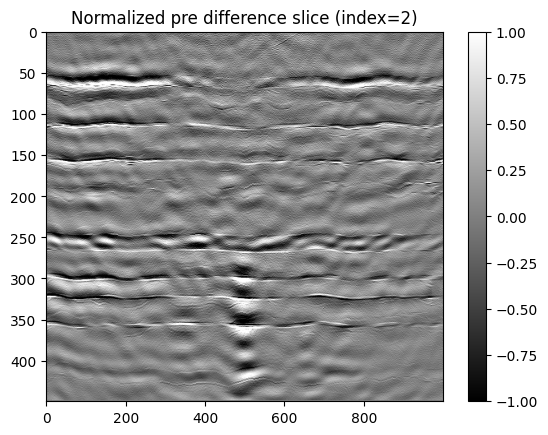

In [4]:
data_norm_pre  = dn.clip_and_normalize(image_diff_pre,  depth_windowing=450)
data_norm_post = dn.clip_and_normalize(image_diff_post, depth_windowing=450)
print("data_norm_pre shape:", data_norm_pre.shape)
print("data_norm_post shape:", data_norm_post.shape)

# Quick visualize a single slice
idx = 2
plt.imshow(data_norm_post[idx].T, aspect="auto", cmap="gray")
plt.colorbar()
plt.title("Normalized pre difference slice (index=2)")
plt.show()


## Step 4: Build Training Dataset (patch extraction)
We'll extract patches from the "pre-injection" differences only, then train the CAE.
We use 49/99 preinjection images for training. 

In [5]:
data_train = dn.build_dataset_from_slices(data_norm_pre[:49],
                                          patch_size=128,
                                          slide_x=10, 
                                          slide_z=10)
print("data_train shape:", data_train.shape)


data_train shape: (142296, 1, 128, 128)


## Step 5: Train Autoencoder
We'll train for a certain number of epochs. The script saves the best model weights to disk.


In [14]:
model_save_path='model_ae_best.pth'
model = dn.train_autoencoder(
    data_train=data_train, 
    cae_model_class=cae.CAE,
    num_epochs=50,
    batch_size=2048,
    model_save_path='model_ae_best.pth',
    device=device
)
print("Autoencoder training complete. Best model saved to:", model_save_path)


NameError: name 'data_train' is not defined